### 데이터 전처리


In [59]:
from util import preprocessing_simple_train
from util import month_to_day, make_mean
import pandas as pd
import numpy as np

mean_df = preprocessing_simple_train("fast")
tmp = month_to_day(mean_df['rainfall_train.ef_month']) + mean_df['rainfall_train.ef_day'] 

mean_df['daysin'] = np.sin(tmp)
mean_df['daycos'] = np.cos(tmp)
mean_df['day'] = tmp
mean_df = make_mean(mean_df,15)
r_df = pd.read_csv('./data/rainfall_train.csv')[['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','rainfall_train.class_interval']]
r_df = r_df[r_df['rainfall_train.class_interval'] != -999]


In [60]:
with open("./data/cluster.json",'r') as f:
    _dict= eval(f.read())
mean_df['cluster'] = 0
for i in range(4):
        mean_df.loc[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)])))),'cluster'] = i

### 테스트/ 검증 데이터 결정
####  테스트데이터

In [153]:
from util import make_day2class, make_day2freqclass
import pandas as pd 
from sklearn.preprocessing import StandardScaler

_year = "A"

train_df = mean_df[mean_df['rainfall_train.ef_year'] != _year].reset_index(drop=True).copy()
test_df = mean_df[mean_df['rainfall_train.ef_year'] == _year].reset_index(drop=True).copy()
rtrain_df = r_df[r_df['rainfall_train.ef_year'] != _year].reset_index(drop=True).copy()
rtest_df = r_df[r_df['rainfall_train.ef_year'] == _year].reset_index(drop=True).copy()

cluster_list_train = []


day2classall = make_day2class(train_df)
day2freqclass = make_day2freqclass(train_df)
day2classall=day2classall.rename(columns={"rainfall_train.class_interval":"mean_class"})
day2freqclass=day2freqclass.rename(columns={"rainfall_train.class_interval":"freq_class"})

train_df = pd.merge(train_df,day2classall,how="left",on=['day']).copy()
train_df = pd.merge(train_df,day2freqclass,how="left",on=['day']).copy()
train_df['freq_class'] = train_df['freq_class'].fillna(0)

test_df = pd.merge(test_df,day2classall,how="left",on=['day']).copy()
test_df = pd.merge(test_df,day2freqclass,how="left",on=['day']).copy()
test_df['freq_class'] = test_df['freq_class'].fillna(0)
train_df['cluster_class'] = 0
test_df['cluster_class'] = 0

for i in range(4):
    day2class = make_day2class(train_df[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)]))))])
    day2class=day2class.rename(columns={"rainfall_train.class_interval":"mean_class_tmp"})
    day2class['cluster'] = i
    train_df = pd.merge(train_df,day2class,how='left',on=['cluster','day'])
    train_df['cluster_class'] = train_df['mean_class_tmp'].combine_first(train_df['cluster_class'])
    train_df = train_df.drop(columns=['mean_class_tmp'])
    test_df = pd.merge(test_df,day2class,how='left',on=['cluster','day'])
    test_df['cluster_class'] = test_df['mean_class_tmp'].combine_first(test_df['cluster_class'])
    test_df = test_df.drop(columns=['mean_class_tmp'])
train_df['cluster_class'] = StandardScaler().fit_transform(train_df[['cluster_class']])
test_df['cluster_class'] = StandardScaler().fit_transform(test_df[['cluster_class']])


/tmp/ipykernel_12861/3835711536.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  day2class = make_day2class(train_df[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)]))))])
/tmp/ipykernel_12861/3835711536.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  day2class = make_day2class(train_df[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)]))))])
/tmp/ipykernel_12861/3835711536.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  day2class = make_day2class(train_df[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)]))))])
/tmp/ipykernel_12861/3835711536.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  day2class = make_day2class(train_df[mean_df['rainfall_train.stn4contest'].isin(np.

#### 제출용 데이터

In [154]:
from util import make_day2class
import pandas as pd 
cluster_list_train = []
train_df = mean_df.copy()


day2classall = make_day2class(train_df)
day2classall=day2classall.rename(columns={"rainfall_train.class_interval":"mean_class"})
train_df = pd.merge(train_df,day2classall,how="left",on=['day']).copy()
day2freqclass = make_day2freqclass(train_df)
day2freqclass=day2freqclass.rename(columns={"rainfall_train.class_interval":"freq_class"})
train_df = pd.merge(train_df,day2freqclass,how="left",on=['day']).copy()
day2class_list = []

train_df['cluster_class'] = 0
for i in range(4):
    day2class = make_day2class(train_df[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)]))))])
    day2class=day2class.rename(columns={"rainfall_train.class_interval":"mean_class_tmp"})
    day2class['cluster'] = i
    day2class_list.append(day2class)
    train_df = pd.merge(train_df,day2class,how='left',on=['cluster','day'])
    train_df['cluster_class'] = train_df['mean_class_tmp'].combine_first(train_df['cluster_class'])
    train_df = train_df.drop(columns=['mean_class_tmp'])
train_df['cluster_class'] = StandardScaler().fit_transform(train_df[['cluster_class']])


### 무강수/강수 데이터 만들기

In [155]:
X = train_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','v_median','day','freq_class','rainfall_train.dh_x','cluster_class','cluster'])
X['rainfall_train.ef_hour'] /= 24.0
Y = train_df["rainfall_train.class_interval"]
X_V = test_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','v_median','day','freq_class','rainfall_train.dh_x','cluster_class','cluster'])
X_V['rainfall_train.ef_hour'] /= 24.0
Y_V = test_df["rainfall_train.class_interval"]

## 강수/무강수 분류

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
m_b = ExtraTreesClassifier(n_estimators= 175, criterion = 'log_loss', max_depth = 12,max_leaf_nodes = 45, random_state=42) 
m_b.fit(X,Y==0)
Y_prev = m_b.predict(X_V)
print(f"무강수/강수 분류 accuracy_score: {accuracy_score(Y_V==0,Y_prev)}")

무강수/강수 분류 accuracy_score: 0.9079181839312002


## 강수 무강수 데이터

In [157]:
ctrain_df = train_df[train_df['rainfall_train.class_interval'] != 0]
ctest_df = test_df[test_df['rainfall_train.class_interval'] != 0]


CX = ctrain_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','day','daysin','daycos','mean_vmax','v_median','rainfall_train.v00','freq_class','rainfall_train.dh_x','cluster'])
CX['rainfall_train.ef_hour'] /= 24.0
CY = ctrain_df["rainfall_train.class_interval"]
CX_V = ctest_df.drop(columns=["rainfall_train.stn4contest","rainfall_train.ef_year","rainfall_train.ef_month","rainfall_train.ef_day","rainfall_train.vv","rainfall_train.class_interval",'v_max','day','daysin','daycos','mean_vmax','v_median','rainfall_train.v00','freq_class','rainfall_train.dh_x','cluster'])
CX_V['rainfall_train.ef_hour'] /= 24.0
CY_V = ctest_df["rainfall_train.class_interval"]

In [158]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from util import compute_csi
m_c = ExtraTreesClassifier(n_estimators=175,random_state=42,max_depth=10,criterion='gini')
m_c.fit(CX,CY)
CY_prev =m_c.predict(CX_V)
print(f"train_DH 최소 : {compute_csi(CY,m_c.predict(CX))}")
print(f"valid_DH 최소 : {compute_csi(CY_V,CY_prev)}")

train_DH 최소 : 0.42908393125312866
valid_DH 최소 : 0.3598272138228942


In [159]:
CY_prev =np.where(ctest_df['rainfall_train.dh_x'] >200,ctest_df['freq_class'],CY_prev)
print(f"DH 최소 : {compute_csi(CY_V,CY_prev)}")

DH 최소 : 0.3598272138228942


## 전체 CSI 점수 검증


In [160]:
test_df['prev'] = 0
ctest_df['cprev'] = CY_prev
rtest_df = pd.merge(rtest_df, test_df.loc[Y_prev,['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','prev']], how="left" , on=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour'])
rtest_df = pd.merge(rtest_df, ctest_df[['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','cprev']], how="left" , on=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour'])
rtest_df['prev'] = rtest_df['cprev'].combine_first(rtest_df['prev'])
rtest_df['prev'] = rtest_df['prev'].fillna(1)


/tmp/ipykernel_12861/503635885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctest_df['cprev'] = CY_prev


In [161]:
print(f"최종 CSI : {compute_csi(rtest_df['rainfall_train.class_interval'], rtest_df['prev'])}")

최종 CSI : 0.30646889628334556


['rainfall_train.ef_hour' 'rainfall_train.v01' 'rainfall_train.v02'
 'rainfall_train.v03' 'rainfall_train.v04' 'rainfall_train.v05'
 'rainfall_train.v06' 'rainfall_train.v07' 'rainfall_train.v08'
 'rainfall_train.v09' 'mean_vmedian' 'cluster' 'mean_class']
[0.05629255 0.0552275  0.07859168 0.07006807 0.07754969 0.10675345
 0.12907855 0.10316926 0.04935702 0.02643088 0.10887826 0.03585235
 0.10275074]


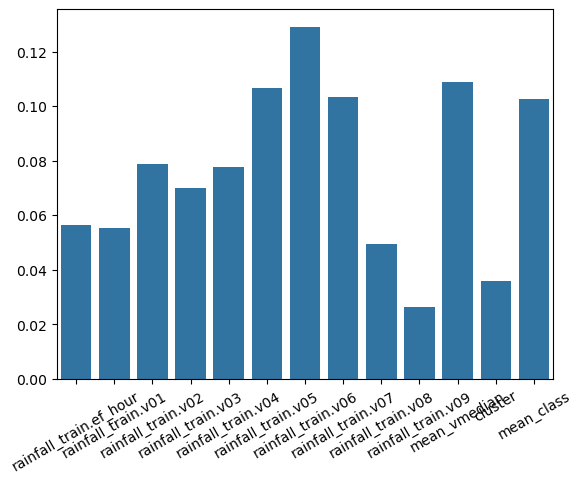

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(x=CX_V.columns.values,y=m_c.feature_importances_)
plt.xticks(rotation=30)
print(CX_V.columns.values)
print(m_c.feature_importances_)

### 제출

In [162]:
from util import preprocessing_simple_test

TEST =preprocessing_simple_test()
TEST['rainfall_test.ef_hour'] /= 24.0
TEST['day'] = month_to_day(TEST["rainfall_test.ef_month"]) + TEST["rainfall_test.ef_day"]
TEST['daysin'] = np.sin(np.pi*2*(TEST['day']/365.0))
TEST['daycos'] = np.cos(np.pi*2*(TEST['day']/365.0))
TEST.columns = TEST.columns.str.replace("rainfall_test","rainfall_train")
TEST = make_mean(TEST)
TEST['cluster'] = 0
for i in range(4):
    TEST.loc[mean_df['rainfall_train.stn4contest'].isin(np.array(list(map(lambda x: f"STN{format(x,'03')}",_dict[str(i)])))),'cluster'] = i
#---
TEST['cluster_class'] = 0
for i in range(4):
    day2class = day2class_list[i]
    TEST = pd.merge(TEST,day2class,how='left',on=['cluster','day'])
    TEST['cluster_class'] = TEST['mean_class_tmp'].combine_first(TEST['cluster_class'])
    TEST = TEST.drop(columns=['mean_class_tmp'])
TEST['cluster_class'] = StandardScaler().fit_transform(TEST[['cluster_class']])
#---
TEST = pd.merge(TEST,day2classall,how="left",on=['day'])
X=TEST.drop(columns=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','v_max','v_median','day','rainfall_train.class_interval','rainfall_train.dh_x','cluster','cluster_class'])
b_pred = m_b.predict(X)
CTEST = TEST[~b_pred].reset_index(drop=True)
X= X[~b_pred].drop(columns=['mean_vmax','rainfall_train.v00','daycos','daysin'])
X['cluster_class'] =TEST.loc[~b_pred,'cluster_class']
CTEST['class'] = m_c.predict(X)
TEST.loc[b_pred, 'rainfall_train.class_interval'] = 0
tmp_df = pd.merge(TEST,CTEST[['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour','class']],how='left',on=['rainfall_train.stn4contest','rainfall_train.ef_year','rainfall_train.ef_month','rainfall_train.ef_day','rainfall_train.ef_hour'])
tmp_df['rainfall_train.class_interval'] = tmp_df['class'].combine_first(tmp_df['rainfall_train.class_interval'])
tmp_df['rainfall_train.ef_hour'] *= 24
tmp_df['rainfall_train.ef_hour'] = tmp_df['rainfall_train.ef_hour'].astype(int)
tmp_df.drop(columns=['class'],inplace=True)
tmp_df = tmp_df.rename(columns={'rainfall_train.class_interval':'class'})
tmp_df.columns = tmp_df.columns.str.replace("rainfall_train", "rainfall_test")

In [163]:
RAW= pd.read_csv("./data/rainfall_test.csv").drop(columns=["Unnamed: 0"])
ind = RAW['rainfall_test.class_interval'] == -999
tt_df = pd.merge(RAW,tmp_df[['rainfall_test.stn4contest','rainfall_test.ef_year','rainfall_test.ef_month','rainfall_test.ef_day','rainfall_test.ef_hour','class']],how='left',on=['rainfall_test.stn4contest','rainfall_test.ef_year','rainfall_test.ef_month','rainfall_test.ef_day','rainfall_test.ef_hour'])
RAW['rainfall_test.class_interval']=tt_df['class'].combine_first(tt_df['rainfall_test.class_interval'])
RAW['rainfall_test.class_interval'] = RAW['rainfall_test.class_interval'].astype(int)
RAW.loc[ind,'rainfall_test.class_interval'] = -999

#### 제출파일 검증

In [164]:
RAW['rainfall_test.class_interval'].value_counts()

rainfall_test.class_interval
 0      103599
 5       12782
 7        1759
 6        1497
 2        1192
 4         761
 9         180
-999       130
 3          80
 8          20
Name: count, dtype: int64

In [165]:
RAW.to_csv('240198.csv',index=False,encoding='euc-kr')